# Self Organising Maps

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

## Introduction and Dataset
For our example we shall go through the process of training and visualising the Map. We will use a dataset of random colours and the aim being to group them. We shall create this dataset (artificially) of 100 colours represented by a 3D Vector (which has R,G,B values)

In [2]:
dataset = np.random.randint(0,255,(3,100))

## Objective

We are given a 3D Matrix of the Colours. What SOMs do is basically 'map' this 3D Matrix into a 2D space. 

This is done so that we can easily visualise the 2D surface and group the similar colours

### Parameters for our SOM

#### SOM Size
It is the dimensions of the of the 2D space in which we will project our 3D Coluor Matrix. Here we will take a 5x5 matrix

#### Learning Parameters

##### Iterations
Another important factor is how many times we train our SOM, since it is an Iterative Process. In this problem we will train the SOM 1500 times. For problems where the dataset is much bigger we would need around 10000 or even more iterations of training.

##### Learning Rate
The learning rate decides by how much we apply changes to our SOM at each iteration. If it’s too high, we will keep making drastic changes to the SOM and might never settle on a solution. If it’s too low, we’ll never get anything done as we will only make very small changes.

In practice it is best to start with a larger learning rate and reduce it slowly over time. This is so that the SOM can start by making big changes but then settle into a solution after a while.

In [36]:
net_dim = np.array([5, 5])
iterations = 1500
learning_rate = 0.01

In [37]:
# Storing the dimensions of the dataset.

m = dataset.shape[0]
n = dataset.shape[1]

# Initialising our initial Neighbourhood Radius

init_radius = max(net_dim[0], net_dim[1])

# Initial Radius Decay Parameter

time_constant = iterations/np.log(init_radius)


# So as mentioned above we wanted to decay the learning rate over time.
# We also want to decay the radius parameter, which basically tells us
# how far we search for 2D neighbours when updating vectors in the SOM.

In [38]:
# Setup random weights between 0 and 1
# The weight matrix (i.e. the SOM) needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((net_dim[0], net_dim[1], m))

## Normalisation

One fact about SOMs, just like most other DL Algorithms is that it trains faster and better if the data values are in between 0 and 1, as we prevent one feature(having a large value) from dominating the whole network due to higher preference.

Since we have 3 dimensions in our dataset between 0 and 255 we will Normalise it column by column.

In [39]:
normalise_data = True

# If all the Data is on a common scale it will be True
normalise_by_column = False

# Storing a Copy of our dataset.
data = dataset

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = dataset.max(axis=0)
        data = dataset / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = dataset / data.max()

## Learning Process

Learning Steps can broadly be classified into the following parts:

- Find the neuron in the SOM whose associated Input(3D) vector is closest to our chosen Input(3D) colour vector and this can be done using the Best Matching Unit (BMU)    
    
- Move the BMU’s 3D weight vector closer to the input vector in 3D space
    
- Identify the SOM's(2D) neighbours of the BMU and also move their Input(3D) weight vectors closer to the input vector, although by a smaller amount
    
- Update the learning rate (reduce it at each iteration)

### Calculating the BMU

Every node is examined to calculate which one’s weights are most like the input vector. 

The node whose weights are most similar is known as the Best Matching Unit (BMU).

The process of Finding the BMU:

    - Initially assign a random input vector.
    - Find the Best Matching Unit with the help of the find_bmu function.
    - Update the Learning Parameters

In [40]:
# This function iterates through each neuron in the SOM, 
# measures the Euclidian Distance between
# the input vector and the Neuron.
# It returns the value which is which is closest to the input vector.


def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

### Selecting a Random training example and finding its Best Matching Unit

In [41]:
# select a training example at random
t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))

# find its Best Matching Unit
bmu, bmu_idx = find_bmu(t, net, m)


### Updating the Learning Parameters

The functions we will use to decay the radius and Learning Rate is the  exponential decay function which is given by:



Where $\lambda$ is the time constant (which controls the decay) and $\sigma$ is the value at various times $t$.

In [42]:
# As mentioned above we will be updating
# the radius and learning rate (reduce it gradually)
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

### Moving the weights

We have obtained both the BMU and updated learning parameters. So now we can update the SOM in such a way that this BMU which we obtained from the Input space is closer to the colour mapped to that Unit. 

We can also identify the neurons that are close to the BMU in SOM space and update their Input vectors to move towards the BMU.

**We use this formula to update the 3D Image Vector:**


So we can say that the new weight vector will be the current weight vector plus the difference between the input vector $V$ and the weight vector, multiplied by a learning rate $L$ at time $t$.

As you can see we are trying to move this weight vector closer to the input vector.

**We also do the same thing for the 2D space(SOM) but the difference here is that the weight update will be proportional to the 2D distance from the BMU**

In [43]:
# Update the weight vector to move closer to the input
# and move its neighbours in 2-D vector space(SOM) closer
# by a factor proportional to their 2-D distance from the BMU

def mov_weights(r, t):
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)

            # Obtaining the 2D distance again from the BMU.
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            w_dist = np.sqrt(w_dist)

            # If this distance is within the current neighbourhood
            if w_dist <= r:
                # Calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)

                # Update the Neuron's weight.
                new_w = w + (l * influence * (t - w))

                # Add the new weight
                net[x, y, :] = new_w.reshape(1, 3)

### Calculating the Influence

Since the proportion of the 2D Distance is not uniform, to pull the neighbouring neurons closer the Gaussian function is used.

The equation we use to calculate the influence of the neighbours:



where $d$ is the 2D distance and $\sigma$ is the current radius of our neighbourhood.

In [44]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

## Integrating everything above here

In [45]:
for i in range(iterations):
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(learning_rate, i, iterations)
    
    # Moving the weights
    mov_weights(r,t)

## Plotting the SOM 

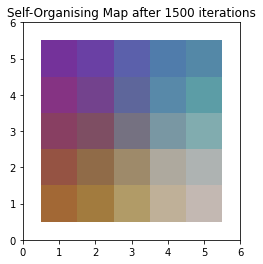

In [46]:
fig = plt.figure()
# First we shall setyp our axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % iterations)

# Plotting the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

We disn't even know what were the Colours in our dataset but by just moving the 3D weight vectors to more closely  match our input vectors, we’ve created a 2D colour space (SOM) which clearly shows us the relationship between colours. 


In this example more of the reddish colours get mapped to the right hand side of the SOM while the the Blue colours get mapped to the left hand side.

### If we tried with 2000 Iterations
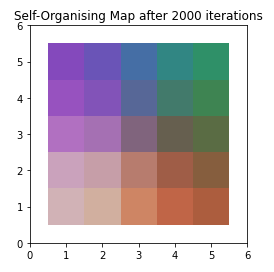

### If we tried with 3000 iterations
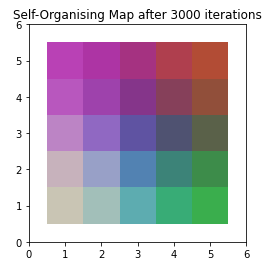

**As you can clearly see for different iterations the Map "organises" (or maps) the colours in different ways**

# Conclusion

The basic concept of a SOM is that we map a high dimensional Vector to a simpler 2D Space. 

It is very similar to K-means Clustering, which brings us to the question, **What is the difference between SOMs and K-Means Clustering?**

**In K-means, the clusters are formed through the centroids and the cluster size, where the centroids are independent of each other. And also one has to mention the number of clusters beforehand itself in K-means.**
**Whereas in SOMs we are forming a relationship between the neurons in the Matrix and the input layer and this in turn helps us build the cluster geometrically.**

So in SOMs we preserve the original Topology, as the distances in the 2D space reflects those distances high-dimensional space.


So we just took a random 3D Colour Matrix and grouped the colours by mapping the Matrix to a 2 Dimensional  Self-Organinsing Map. This is a very useful Unsupervised Learning Algorithm which, people say, was used before Back-prop came into the picture.


**Uses of SOMs:**

    - Dimensionality Reduction
    - Visualising High Dimensional Data in 2D space
    - Clustering Problems